In [14]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

Mounted at /content/gdrive
Mounted at /content/gdrive


In [2]:
import my_utils as mu
import torch
from torch import nn
from IPython import display

In [3]:
batch_size = 256
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [4]:
#defining Network
from torch import nn , optim

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet,self).__init__()
        self.L1 = nn.Linear(49, 178)
        self.L2 = nn.Linear(16, 156)
        self.L3 = nn.Linear(156, 112)
        self.L4 = nn.Linear(178, 120)
        self.L5 = nn.Linear(120, 16)
        self.L6 = nn.Linear(16, 40)
        self.L7 = nn.Linear(40, 10)
        self.relu = nn.ReLU()# activation function
        self.dropout = nn.Dropout(0.2)#A dropout layer sets a certain amount of neurons to zero.
        
        
        
        
    def forward(self, x):
      # Creating 7x7 patches from images
      x = x.squeeze()# Removes single-dimensional entries from an array,
      x= x.unfold(1,7,7).unfold(2,7,7)# unfold to obtain the 7x7 patches
      x = x.contiguous().view(-1,16,7*7)
      dout = self.L1(x)

        
       # MLP 1 
      dout = torch.transpose(dout,1,2)
      dout = self.L2(dout)
      dout = self.relu(dout)
      dout = self.dropout(dout)
      dout = self.L3(dout)
      dout = torch.transpose(dout,1,2)
      dout = self.L4(dout)
      dout = self.relu(dout)
      dout = self.dropout(dout)
      dout = self.L5(dout)

      # MLP 2
      dout = self.L6(dout)
      dout = self.L7(dout)
      dout = torch.mean(dout,1)
      

        
      return dout
net = MLPNet()


In [5]:
loss = nn.CrossEntropyLoss()

In [6]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01) 


# Evaluation


In [7]:
def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class.
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # Predicted class is the index of max score         
    cmp = (y_hat.type(y.dtype) == y)  # because`==` is sensitive to data types
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.

# Example: only 1 sample is correctly classified.
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
accuracy(y_hat, y) / len(y)

0.5

In [8]:
class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [9]:
def evaluate_accuracy(net, data_iter): 
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [10]:
evaluate_accuracy(net, test_iter)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.1035

In [11]:
def train_epoch_ch3(net, train_iter, loss, optimizer, batch_size=256, num_outputs=10):  
    """The training function for one epoch."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [12]:
class Animator:  
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        mu.use_svg_display()
        self.fig, self.axes = mu.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: mu.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [13]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer): 
    """Train a model."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    print(test_acc)
    train_loss, train_acc = train_metrics

0.8456


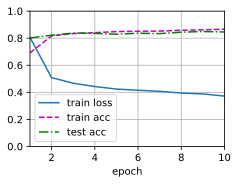

In [15]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer)